In [1]:
import torch, platform, os
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version   :", torch.version.cuda)
print("GPU seen       :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "-")

2.6.0+cu124
CUDA available: True
CUDA version   : 12.4
GPU seen       : Quadro T2000


In [2]:
import healpy
import numpy as np

def segment_sample(data, orientation, segment_len=64, with_roll=False):
    height, width, num_cols = data.shape
    if orientation == 'vertical':
        data = np.transpose(data, (1, 0, 2))
    # random roll in first two dimensions
    if with_roll:
        data = np.roll(data, np.random.randint(-5, 5), axis=(0, 1))
    segments = np.zeros((height*width // segment_len, num_cols, segment_len), dtype=np.float32)
    for i in range(num_cols):
        segments[:, i, :] = data[:, :, i].reshape(height*width // segment_len, segment_len)
    return segments

from fco2dataset.ucollocate import get_day_data, collocate
def get_day_dataset(date):
    # get global satellite data for a given date
    dss = get_day_data(date, save_path='../data/inference/gridded')
    return dss

def collocate_coords(df, dss, date):
    save_path = '../data/inference/collocated'
    df_collocated = collocate(df, date, save_path=save_path, dss=dss, verbose=False)
    return df_collocated

def normalize(df, stats, mode):
    for i in range(1, len(stats['means'])): # first column is the target
        col = df.columns[i - 1]
        # print(f"Normalizing {col} with {mode}")
        if mode == 'min_max':
            # print(f"Min: {stats['mins'][i]}, Max: {stats['maxs'][i]}")
            df[col] = 2 * (df[col] - stats['mins'][i]) / (stats['maxs'][i] - stats['mins'][i]) - 1
        elif mode == 'mean_std':
            df[col] = (df[col] - stats['means'][i]) / stats['stds'][i]
        else:
            raise ValueError(f"Unknown mode {mode}")
    return df

In [3]:
import healpy as hp

def get_nested_patch(patch_ix, patch_size, nside=1024, plot=False):
    patch_pix = np.arange(patch_ix * patch_size, (patch_ix + 1) * patch_size)
    xyf = hp.pix2xyf(nside, patch_pix, nest=True)
    xyf = (xyf[0]  - xyf[0].min(), xyf[1]  - xyf[1].min(), xyf[2])
    lon, lat = hp.pix2ang(nside, patch_pix, nest=True, lonlat=True)

    if plot:
        side = int(np.sqrt(patch_size))
        plot_patch(patch_ix, patch_size, xyf[0] * side + xyf[1], nside=nside)
    return xyf, lon, lat, patch_pix

def plot_patch(patch_ix, patch_size, data, nside=1024):
    npix = hp.nside2npix(nside)
    m = np.full(npix, np.nan)
    patch_pix = np.arange(patch_ix * patch_size, (patch_ix + 1) * patch_size)
    m[patch_pix] = data
    hp.mollview(m, title=f"Patch {patch_ix}", nest=True)


Number of patches: 48


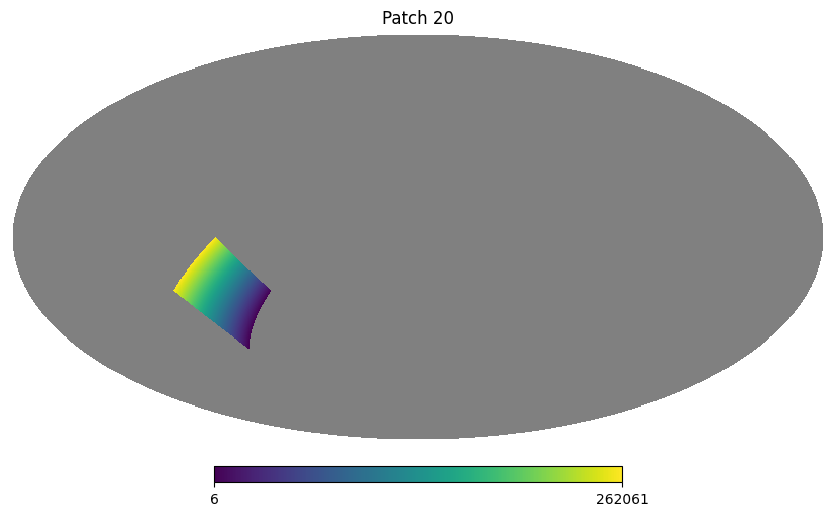

In [4]:
NSIDE = 1024
npix = hp.nside2npix(NSIDE)
face_pixs = npix//12
num_subfaces = 4 # number of subfaces should a power of 4
patch_size = face_pixs // num_subfaces
n_patches = npix // patch_size
print(f"Number of patches: {n_patches}")
xyf, lon, lat, patch_pix = get_nested_patch(20, patch_size, nside=NSIDE, plot=True)


In [5]:
import pandas as pd
from fco2models.utraining import prep_df
def get_patch_ds(params, patch_ix, patch_size, date, nside=NSIDE, dss=None):
    predictors = params['predictors']
    stats = {
    'means':params['train_means'],
    'stds':params['train_stds'],
    'mins':params['train_mins'],
    'maxs':params['train_maxs']
    }

    # get the patch coordinates
    xyf, lon, lat, patch_pix = get_nested_patch(patch_ix, patch_size, nside=nside)
    if dss is None:
        dss = get_day_dataset(date)
    coords = pd.DataFrame({
        'lon': lon.flatten(),
        'lat': lat.flatten(),
        'x': xyf[0].flatten(),
        'y': xyf[1].flatten(),
        'f': xyf[2].flatten(),
        'patch_pix': patch_pix,
    })
    coords['time_1d'] = date
    # collocate the data
    context_df = collocate_coords(coords, dss, date)
    context_df['lon'] = (context_df['lon'] + 180) % 360 - 180
    context_df = prep_df(context_df, with_target=False, with_log=False)[0][predictors + ['x', 'y']]
    context_df = normalize(context_df, stats, params['mode'])

    height = width = np.sqrt(patch_size).astype(int)
    context_ds = np.zeros((height, width, len(predictors) + 3), dtype=np.float32)
    x = context_df['x'].values.astype(int)
    y = context_df['y'].values.astype(int)
    for i, col in enumerate(predictors):
        context_ds[x, y, i] = context_df[col].values
    # add lat lon
    context_ds[x, y, -2] = lat
    context_ds[x, y, -1] = lon
    context_ds[x, y, -3] = patch_pix.flatten()

    return context_ds

import torch
from tqdm import tqdm
def infer_patch(model, noise_scheduler, params, patch_ix, patch_size, date, nside=NSIDE, dss=None, jump=20):
    # get the patch data
    context_ds = get_patch_ds(params, patch_ix, patch_size, date, nside=nside, dss=dss)
    lat = context_ds[:, :, -2]
    lon = context_ds[:, :, -1]
    patch_pix = context_ds[:, :, -3]
    context_ds = context_ds[:, :, :-3]
    height = width = np.sqrt(patch_size).astype(int)
    sample_col = np.random.randn(height, width, 1).astype(np.float32)
    sample_context_ds = np.concatenate([sample_col, context_ds, np.ones_like(sample_col)], axis=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    step = 0
    t_loop = tqdm(noise_scheduler.timesteps[::jump], desc="Denoising steps")
    
    for t in t_loop:
        if step % 2 == 0:
            segments = segment_sample(sample_context_ds.copy(), 'horizontal', segment_len=64)
        else:
            segments = segment_sample(sample_context_ds.copy(), 'vertical', segment_len=64)

        ds = torch.from_numpy(segments).to(device).float()
        #print(f"ds shape: {ds.shape}")
        dataloader = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=False)
        samples = []
        for (ix, batch) in enumerate(dataloader):
            with torch.no_grad():
                batch = batch.to(device)
                #context = batch[:, 1:, :].to(device)
                sample_prev = batch[:, 0:1, :].to(device)
                noise_pred = model(batch, t, return_dict=False)[0]
                x_0 = noise_scheduler.step(noise_pred, t, sample_prev).pred_original_sample
                if t - jump > 0:
                    sample = noise_scheduler.add_noise(x_0, torch.randn_like(sample_prev), t - jump)
                else:
                    sample = x_0
                sample[torch.isnan(sample)] = sample_prev[torch.isnan(sample)]
                samples.append(sample.cpu().numpy())
            t_loop.set_postfix({"batch":{ix}})
        
        samples = np.concatenate(samples, axis=0)
        if step % 2 == 0:
            samples = samples.reshape(height, width, 1)
        else:
            samples = samples.reshape(width, height).T[:, :, np.newaxis]
        #print(f"Samples shape: {samples.shape}")
        sample_context_ds = np.concatenate([samples, context_ds, np.ones_like(sample_col)], axis=2)
        step += 1
        # count nans percentage in the sample array
        #print(f"Number of nans in the sample array: {np.isnan(samples).sum() / samples.size * 100:.2f}%")
        #print(f"Step {step} done")
    return np.concatenate([sample_context_ds, lat[:,:, np.newaxis], lon[:,:, np.newaxis], patch_pix[:, :, np.newaxis]], axis=2)

    

In [9]:
from fco2models.models import UNet2DModelWrapper, UNet1DModel
from fco2models.ueval import load_model
import torch
# load baseline model
save_path = '../models/constlr/pointpos/'
model_path = 'e_100.pt'
model_class = UNet2DModelWrapper
model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class)
print("model loaded")
date = pd.Timestamp('2022-10-04')
dss = get_day_dataset(date)

face_pixs = npix//12
num_subfaces = 4 # number of subfaces should a power of 4
patch_size = face_pixs // num_subfaces
print(f"Number of patches: {n_patches}")
print(f"Patch size: {patch_size}")

patch_ixs = [20, 21, 22, 23]
samples = []
for patch_ix in patch_ixs:
    sample = infer_patch(model, noise_scheduler, params, patch_ix, patch_size, date, nside=NSIDE, dss=dss)
    samples.append(sample)

sample = np.concatenate(samples, axis=0)

model loaded
All files reachable for date 2022-10-04 00:00:00
globcolour data already exists at ../data/inference/gridded_2022-10-04/globcolour.nc
soda data already exists at ../data/inference/gridded_2022-10-04/soda.nc
cmems data already exists at ../data/inference/gridded_2022-10-04/cmems.nc
sss_cci data already exists at ../data/inference/gridded_2022-10-04/sss_cci.nc
sss_multiobs data already exists at ../data/inference/gridded_2022-10-04/sss_multiobs.nc
sst_cci data already exists at ../data/inference/gridded_2022-10-04/sst_cci.nc
Reading globcolour data from ../data/inference/gridded_2022-10-04/globcolour.nc
Reading soda data from ../data/inference/gridded_2022-10-04/soda.nc
Reading cmems data from ../data/inference/gridded_2022-10-04/cmems.nc
Reading sss_cci data from ../data/inference/gridded_2022-10-04/sss_cci.nc
Reading sss_multiobs data from ../data/inference/gridded_2022-10-04/sss_multiobs.nc
Reading sst_cci data from ../data/inference/gridded_2022-10-04/sst_cci.nc
Number o

Denoising steps: 100%|██████████| 50/50 [02:01<00:00,  2.44s/it, batch={63}]


In [10]:
np.isnan(sample).sum() / sample.size * 100

np.float64(7.005641039680032)

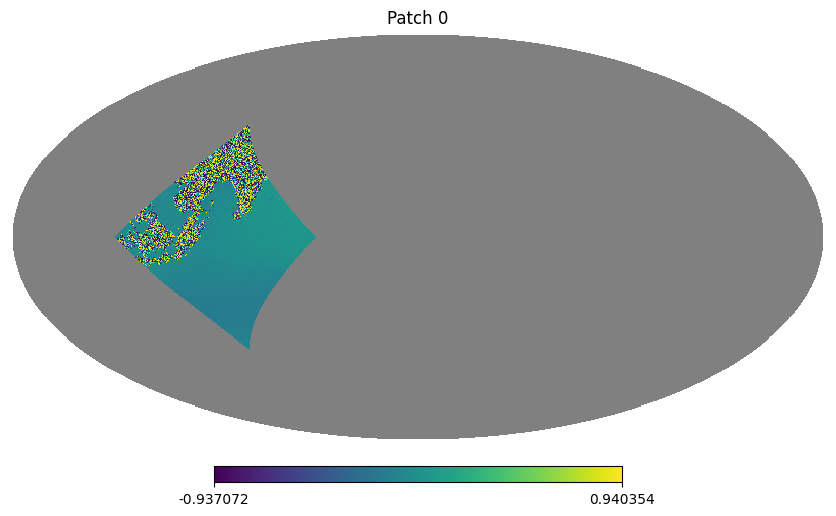

In [11]:
m = np.full(npix, np.nan)
#patch_pix = np.arange(0 * patch_size, (0 + 1) * patch_size)
patch_pix = sample[:, :, -1].flatten().astype(int)
# clip sample between 5th and 95th percentile
robust_sample = np.clip(sample[:, :, 0], np.nanpercentile(sample[:, :, 0], 5), np.nanpercentile(sample[:, :, 0], 95))
m[patch_pix] = robust_sample.flatten()
hp.mollview(m, title=f"Patch {0}", nest=True)